In [1]:
 pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 16.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import random
import itertools
from sklearn.metrics import recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform
import scipy
from implicit.nearest_neighbours import bm25_weight
import implicit

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

print('pandas version:', pd.__version__)
print('numpy version:', np.__version__)
print('scipy version:', scipy.__version__)
print('implicit version:', implicit.__version__)

pandas version: 2.1.4
numpy version: 1.26.4
scipy version: 1.13.1
implicit version: 0.7.2


In [3]:
os.getcwd()

'/content'

In [4]:
DATA_PATH = './drive/MyDrive/Colab Notebooks/article'
files_list = glob.glob(f'{DATA_PATH}/*.csv')

files_list

['./drive/MyDrive/Colab Notebooks/article/view_log.csv',
 './drive/MyDrive/Colab Notebooks/article/sample_submission.csv',
 './drive/MyDrive/Colab Notebooks/article/article_info.csv']

In [5]:
os.chdir(DATA_PATH)

In [6]:
view_train = pd.read_csv('view_log.csv')
article_info = pd.read_csv('article_info.csv')
submission = pd.read_csv('sample_submission.csv')

# EDA

In [7]:
view_train.head()

,userID,articleID,userRegion,userCountry
0,USER_0000,ARTICLE_0661,NY,US
1,USER_0000,ARTICLE_2316,NY,US
2,USER_0000,ARTICLE_1345,NY,US
3,USER_0000,ARTICLE_1089,NY,US
4,USER_0000,ARTICLE_1484,NY,US


In [8]:
view_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42717 entries, 0 to 42716
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   userID       42717 non-null  object
 1   articleID    42717 non-null  object
 2   userRegion   42717 non-null  object
 3   userCountry  42717 non-null  object
dtypes: object(4)
memory usage: 1.3+ MB


In [9]:
view_train.describe()

,userID,articleID,userRegion,userCountry
count,42717,42717,42717,42717
unique,1415,2879,56,21
top,USER_0222,ARTICLE_2868,SP,BR
freq,974,291,30127,38566


In [10]:
article_info.head()

,articleID,Title,Content,Format,Language,userID,userCountry,userRegion
0,ARTICLE_0000,19 Tips For Everyday Git Use,I've been using git full time for the past 4 y...,HTML,en,USER_0683,NaN,NaN
1,ARTICLE_0001,Intel buys computer vision startup Itseez to i...,Intel has acquired computer vision and machine...,HTML,en,USER_1129,NaN,NaN
2,ARTICLE_0002,Practical End-to-End Testing with Protractor,One of the reasons AngularJS is so great to wo...,HTML,en,USER_0256,NaN,NaN
3,ARTICLE_0003,Corporate venture growth in Brazil is another ...,Despite recent positive news and a renewed int...,HTML,en,USER_1304,NaN,NaN
4,ARTICLE_0004,Cross-channel user experiences with Drupal (aw...,"Last year around this time, I wrote that The B...",HTML,en,USER_0336,NaN,NaN


In [11]:
article_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008 entries, 0 to 3007
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   articleID    3008 non-null   object
 1   Title        3008 non-null   object
 2   Content      3008 non-null   object
 3   Format       3008 non-null   object
 4   Language     3008 non-null   object
 5   userID       3008 non-null   object
 6   userCountry  659 non-null    object
 7   userRegion   657 non-null    object
dtypes: object(8)
memory usage: 188.1+ KB


In [12]:
article_info.describe()

,articleID,Title,Content,Format,Language,userID,userCountry,userRegion
count,3008,3008,3008,3008,3008,3008,659,657
unique,3008,3008,3004,3,5,251,5,17
top,ARTICLE_0000,19 Tips For Everyday Git Use,Create a FREE account to: Get eight free artic...,HTML,en,USER_1063,BR,SP
freq,1,1,3,2988,2176,303,595,522


In [13]:
print(view_train.isnull().sum())
print(article_info.isnull().sum())

userID         0
articleID      0
userRegion     0
userCountry    0
dtype: int64
articleID         0
Title             0
Content           0
Format            0
Language          0
userID            0
userCountry    2349
userRegion     2351
dtype: int64


In [14]:
unique_users = view_train.drop_duplicates(subset = 'userID')

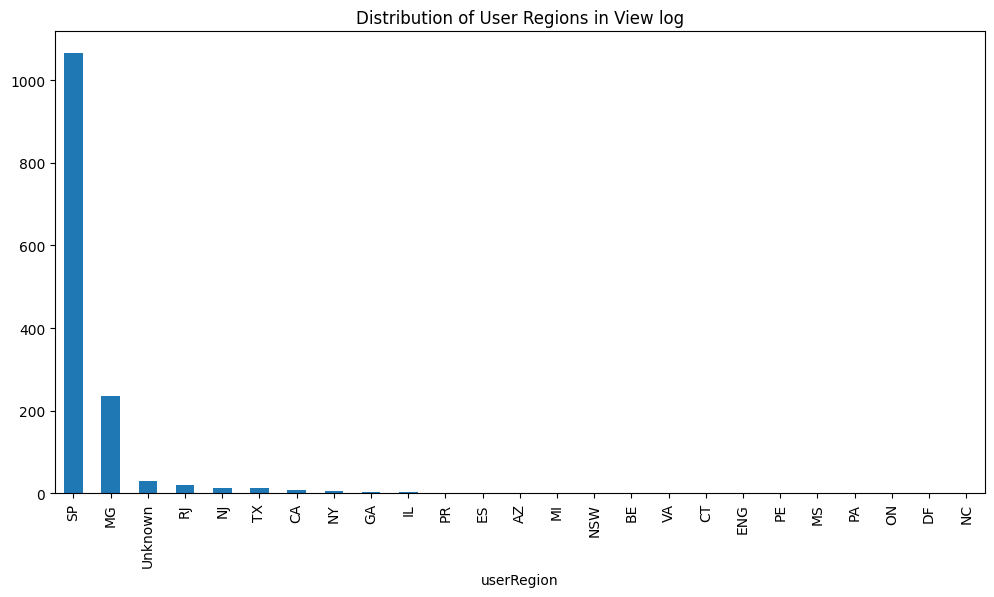

In [15]:
plt.figure(figsize=(12,6))
unique_users['userRegion'].value_counts().plot(kind='bar')
plt.title('Distribution of User Regions in View log')
plt.show()

In [16]:
# userRegion에 NULL값 말고도 Unknown인 값 30개
print(unique_users[unique_users['userRegion'] == 'Unknown'].shape[0])

30


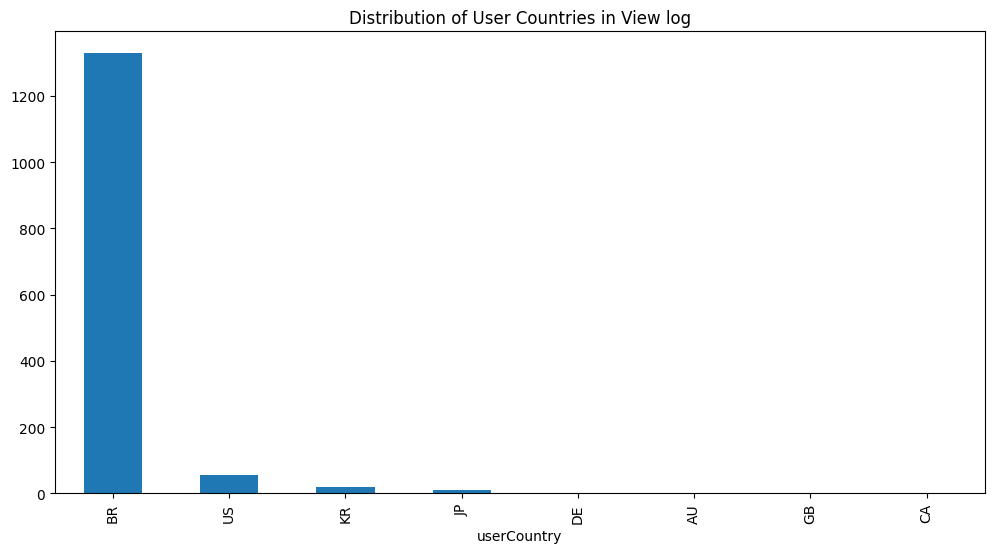

In [17]:
plt.figure(figsize=(12,6))
unique_users['userCountry'].value_counts().plot(kind='bar')
plt.title('Distribution of User Countries in View log')
plt.show()

In [18]:
user_article_df = view_train.groupby(['userID', 'articleID']).size().reset_index(name='count')
user_article_df

,userID,articleID,count
0,USER_0000,ARTICLE_0090,1
1,USER_0000,ARTICLE_0411,3
2,USER_0000,ARTICLE_0661,1
3,USER_0000,ARTICLE_0732,1
4,USER_0000,ARTICLE_0884,1
...,...,...,...
31654,USER_1420,ARTICLE_2723,2
31655,USER_1420,ARTICLE_2726,1
31656,USER_1420,ARTICLE_2779,1
31657,USER_1420,ARTICLE_2865,1


In [19]:
# 대부분의 사용자가 특정 기사를 한 번씩만 조회하지만 최대 34회까지 조회한 사용자-기사 pair도 존재함
user_article_df['count'].value_counts()

,count
count,
1,25654
2,3885
3,1091
4,471
5,226
6,106
7,60
8,38
9,36


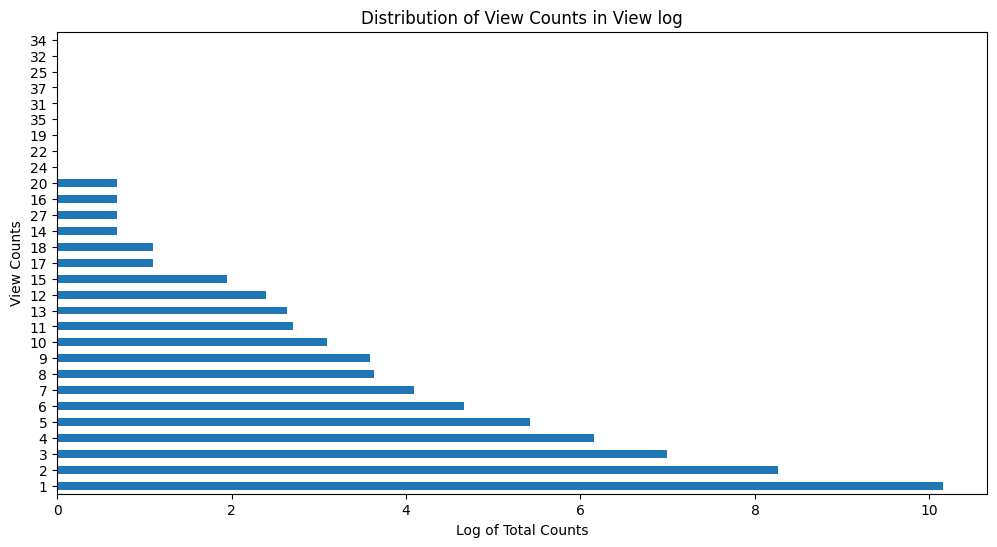

In [20]:
logcount = np.log(user_article_df['count'].value_counts())

plt.figure(figsize=(12,6))
logcount.plot(kind='barh')
plt.title('Distribution of View Counts in View log')
plt.xlabel('Log of Total Counts')
plt.ylabel('View Counts')
plt.show()

In [21]:
articles_per_user = user_article_df.groupby('userID').size().reset_index(name='counts')
articles_per_user.describe()

,counts
count,1415.000000
mean,22.373852
std,47.541638
min,1.000000
25%,4.000000
50%,8.000000
75%,21.000000
max,771.000000


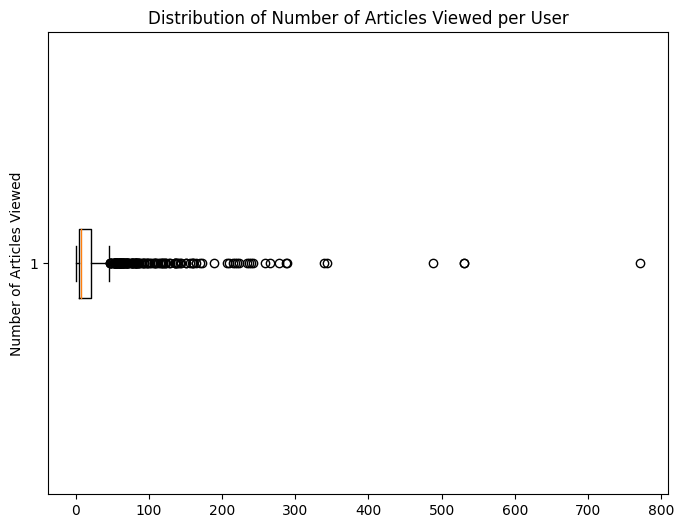

In [22]:
plt.figure(figsize=(8, 6))
plt.boxplot(articles_per_user['counts'], vert=False)
plt.title('Distribution of Number of Articles Viewed per User')
plt.ylabel('Number of Articles Viewed')
plt.show()

# Baseline

In [23]:
# User-Article Matrix
user_article_matrix = view_train.groupby(['userID', 'articleID']).size().unstack(fill_value=0)

# User Similarity
user_similarity = cosine_similarity(user_article_matrix)
user_similarity

array([[1.        , 0.        , 0.        , ..., 0.02571722, 0.        ,
        0.01028689],
       [0.        , 1.        , 0.        , ..., 0.        , 0.00847884,
        0.02581989],
       [0.        , 0.        , 1.        , ..., 0.        , 0.06495046,
        0.        ],
       ...,
       [0.02571722, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.00847884, 0.06495046, ..., 0.        , 1.        ,
        0.        ],
       [0.01028689, 0.02581989, 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [24]:
user_article_matrix.shape

(1415, 2879)

In [25]:
# score
user_predicted_scores = user_similarity.dot(user_article_matrix)/np.array([np.abs(user_similarity).sum(axis=1)]).T

In [26]:
# 이미 조회한 기사 포함해서 추천
recommendations = []
for idx, user in enumerate(user_article_matrix.index):
    # 해당 사용자의 추천 점수 (높은 점수부터 정렬)
    sorted_indices = user_predicted_scores[idx].argsort()[::-1]
    top5recommend = [article for article in user_article_matrix.columns[sorted_indices]][:5]

    for article in top5recommend:
        recommendations.append([user, article])

In [27]:
# sample_submission.csv 형태로 Dataframe 생성
top_recommendations = pd.DataFrame(recommendations, columns=['userID', 'articleID'])

submission['articleID'] = top_recommendations['articleID']

# submission.to_csv('baseline_submission.csv', index=False)

# Pre-Processing

In [28]:
view_train = view_train.drop(columns=['userRegion', 'userCountry'])
view_train.shape

(42717, 2)

# Train-Validation Split

In [29]:
# Overfitting을 방지하기 위해 10개 이상의 interaction이 있는 사용자들로만 학습에 사용함
user_subset = view_train.groupby('userID').size()
user_subset = user_subset[user_subset >= 10].index
view_train = view_train[view_train['userID'].isin(user_subset)]
view_train.shape

(39813, 2)

In [30]:
len(view_train['userID'].unique())

749

In [31]:
# Validation set에 각 사용자별로 랜덤한 사용자-기사 pair 5개가 포함되도록 설정하고 Recall@5가 이 5개를 예측하도록 튜닝함

def create_validation_set(view_train, n=5):
  validation_indices = []
  for user in view_train['userID'].unique():
    user_data = view_train[view_train['userID'] == user]
    validation_indices += random.sample(list(user_data.index), n)
  validation_set = view_train.loc[validation_indices]
  train_set = view_train.drop(validation_indices)

  return train_set, validation_set

train_set, validation_set = create_validation_set(view_train)

In [32]:
print(train_set.shape)
print(validation_set.shape)

(36068, 2)
(3745, 2)


# Hyperparameter Tuning

In [33]:
train_matrix = train_set.groupby(['userID', 'articleID']).size().unstack(fill_value=0)
train_matrix_bm25 = bm25_weight(train_matrix, K1=3.95, B=0.2)
Xui_train = scipy.sparse.csr_matrix(train_matrix_bm25)

In [34]:
def hyperparameter_tuning(train_set, validation_set, param_grid, max_iter):
    best_recall = 0
    best_params = None

    param_combinations = list(itertools.product(*param_grid.values()))
    random.shuffle(param_combinations)

    param_combinations = param_combinations[:max_iter]


    for i, params in enumerate(param_combinations, start=1):
        param_dict = dict(zip(param_grid.keys(), params))

        # 모델 정의
        model = implicit.cpu.lmf.LogisticMatrixFactorization(
            factors=param_dict['factors'],
            learning_rate=param_dict['learning_rate'],
            regularization=param_dict['regularization'],
            iterations=param_dict['iterations'],
            neg_prop=param_dict['neg_prop'],
            random_state=42
        )

        model.fit(Xui_train)

        user_list = list(train_set['userID'].unique()) # Get unique user IDs from training set
        item_list = list(train_set['articleID'].unique()) # Get unique item IDs from training set
        recall = evaluate_model(model, train_set, validation_set, param_dict['K1'], param_dict['B'], user_list, item_list)

        print(f"Iteration{i}/{max_iter}: K1={param_dict['K1']}, B={param_dict['B']}, factors={param_dict['factors']}, learning_rate={param_dict['learning_rate']}, regularization={param_dict['regularization']}, iterations={param_dict['iterations']}, neg_prop={param_dict['neg_prop']}, Recall@5={recall}")


        if recall > best_recall:
            best_recall = recall
            best_params = param_dict

    return best_params, best_recall


def evaluate_model(model, train_set, validation_set, K1, B, user_list, item_list):

    recalls = []
    for idx, user in enumerate(user_list):
      user_index = user_list.index(user)
      recommendations = model.recommend(idx, Xui_train[idx], N=5, filter_already_liked_items=False)
      recommended_articles = [item_list[r] for r in recommendations[0]]

      actual_articles = validation_set[validation_set['userID'] == user]['articleID'].values
      recall = recall_at_k(actual_articles, recommended_articles, k=5)
      recalls.append(recall)

    return np.mean(recalls)

def recall_at_k(actual, predicted, k=5):
    actual_set = set(actual)
    predicted_set = set(predicted[:k])
    return len(actual_set & predicted_set) / len(actual_set)

In [35]:
param_grid = {
    'K1': np.linspace(0.5, 4.5, 20),
    'B': np.linspace(0.2, 10, 20),
    'factors': [100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'regularization': [0.01, 0.1, 1.0, 10.0],
    'iterations': [100, 200, 300],
    'neg_prop': [10, 50, 100, 150]
}

best_params, best_recall = hyperparameter_tuning(train_set, validation_set, param_grid, max_iter=50)

best_params, best_recall

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration1/50: K1=3.2368421052631575, B=0.7157894736842105, factors=200, learning_rate=0.001, regularization=10.0, iterations=100, neg_prop=10, Recall@5=0.000534045393858478


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration2/50: K1=1.3421052631578947, B=1.7473684210526317, factors=200, learning_rate=0.2, regularization=10.0, iterations=300, neg_prop=50, Recall@5=0.00264797507788162


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration3/50: K1=4.078947368421052, B=7.421052631578948, factors=300, learning_rate=0.1, regularization=10.0, iterations=100, neg_prop=150, Recall@5=0.0013351134846461949


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration4/50: K1=4.5, B=9.48421052631579, factors=200, learning_rate=0.01, regularization=1.0, iterations=200, neg_prop=100, Recall@5=0.0008010680907877171


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration5/50: K1=1.3421052631578947, B=8.452631578947368, factors=200, learning_rate=0.1, regularization=10.0, iterations=300, neg_prop=10, Recall@5=0.002113929684023142


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration6/50: K1=0.7105263157894737, B=3.2947368421052636, factors=100, learning_rate=0.2, regularization=0.01, iterations=300, neg_prop=100, Recall@5=0.0018469069870939029


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration7/50: K1=1.131578947368421, B=4.842105263157896, factors=100, learning_rate=0.01, regularization=10.0, iterations=200, neg_prop=10, Recall@5=0.0016021361815754338


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration8/50: K1=0.9210526315789473, B=3.2947368421052636, factors=200, learning_rate=0.01, regularization=0.1, iterations=200, neg_prop=10, Recall@5=0.000267022696929239


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration9/50: K1=3.026315789473684, B=1.231578947368421, factors=100, learning_rate=0.001, regularization=0.01, iterations=100, neg_prop=10, Recall@5=0.0016021361815754338


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration10/50: K1=2.6052631578947367, B=7.936842105263159, factors=300, learning_rate=0.001, regularization=10.0, iterations=100, neg_prop=50, Recall@5=0.0013351134846461949


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration11/50: K1=4.5, B=7.421052631578948, factors=200, learning_rate=0.2, regularization=0.1, iterations=300, neg_prop=150, Recall@5=0.002380952380952381


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration12/50: K1=0.9210526315789473, B=5.357894736842106, factors=100, learning_rate=0.1, regularization=0.1, iterations=100, neg_prop=10, Recall@5=0.001068090787716956


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration13/50: K1=4.289473684210526, B=3.2947368421052636, factors=300, learning_rate=0.1, regularization=10.0, iterations=300, neg_prop=10, Recall@5=0.001579884290164664


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration14/50: K1=4.5, B=3.810526315789474, factors=200, learning_rate=0.001, regularization=0.01, iterations=300, neg_prop=50, Recall@5=0.0008010680907877171


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration15/50: K1=3.2368421052631575, B=0.2, factors=200, learning_rate=0.01, regularization=10.0, iterations=300, neg_prop=100, Recall@5=0.0016021361815754343


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration16/50: K1=0.9210526315789473, B=3.810526315789474, factors=300, learning_rate=0.01, regularization=0.01, iterations=300, neg_prop=100, Recall@5=0.0016021361815754343


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration17/50: K1=2.8157894736842106, B=1.231578947368421, factors=100, learning_rate=0.2, regularization=10.0, iterations=100, neg_prop=50, Recall@5=0.002113929684023142


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration18/50: K1=0.7105263157894737, B=3.2947368421052636, factors=100, learning_rate=0.01, regularization=1.0, iterations=200, neg_prop=100, Recall@5=0.0013351134846461949


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration19/50: K1=3.026315789473684, B=6.905263157894738, factors=300, learning_rate=0.01, regularization=0.1, iterations=200, neg_prop=150, Recall@5=0.0016021361815754343


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration20/50: K1=2.6052631578947367, B=0.7157894736842105, factors=200, learning_rate=0.2, regularization=0.1, iterations=200, neg_prop=150, Recall@5=0.0025367156208277704


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration21/50: K1=3.8684210526315788, B=0.7157894736842105, factors=100, learning_rate=0.2, regularization=10.0, iterations=100, neg_prop=10, Recall@5=0.0018469069870939029


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration22/50: K1=4.289473684210526, B=0.2, factors=100, learning_rate=0.2, regularization=10.0, iterations=300, neg_prop=10, Recall@5=0.001579884290164664


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration23/50: K1=2.8157894736842106, B=6.389473684210527, factors=200, learning_rate=0.2, regularization=0.1, iterations=200, neg_prop=10, Recall@5=0.0017801513128615934


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration24/50: K1=2.1842105263157894, B=6.905263157894738, factors=200, learning_rate=0.1, regularization=10.0, iterations=300, neg_prop=100, Recall@5=0.002113929684023142


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration25/50: K1=3.026315789473684, B=6.389473684210527, factors=200, learning_rate=0.1, regularization=0.01, iterations=200, neg_prop=100, Recall@5=0.00258121940364931


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration26/50: K1=4.5, B=10.0, factors=300, learning_rate=0.01, regularization=0.1, iterations=100, neg_prop=50, Recall@5=0.001869158878504673


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration27/50: K1=3.2368421052631575, B=6.389473684210527, factors=200, learning_rate=0.1, regularization=0.1, iterations=300, neg_prop=10, Recall@5=0.0023141967067200715


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration28/50: K1=1.3421052631578947, B=5.357894736842106, factors=200, learning_rate=0.2, regularization=1.0, iterations=100, neg_prop=100, Recall@5=0.002202937249666222


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration29/50: K1=4.5, B=6.389473684210527, factors=200, learning_rate=0.2, regularization=0.01, iterations=200, neg_prop=150, Recall@5=0.0025367156208277704


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration30/50: K1=0.9210526315789473, B=0.7157894736842105, factors=200, learning_rate=0.001, regularization=0.01, iterations=300, neg_prop=10, Recall@5=0.000534045393858478


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration31/50: K1=3.4473684210526314, B=5.357894736842106, factors=300, learning_rate=0.2, regularization=0.01, iterations=100, neg_prop=100, Recall@5=0.0025589675122385403


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration32/50: K1=4.289473684210526, B=2.7789473684210533, factors=200, learning_rate=0.2, regularization=1.0, iterations=100, neg_prop=10, Recall@5=0.00264797507788162


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration33/50: K1=3.6578947368421053, B=1.7473684210526317, factors=200, learning_rate=0.1, regularization=10.0, iterations=200, neg_prop=150, Recall@5=0.00255896751223854


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration34/50: K1=0.5, B=5.873684210526316, factors=200, learning_rate=0.01, regularization=0.1, iterations=300, neg_prop=50, Recall@5=0.001068090787716956


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration35/50: K1=3.026315789473684, B=5.357894736842106, factors=100, learning_rate=0.001, regularization=10.0, iterations=300, neg_prop=150, Recall@5=0.0016021361815754338


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration36/50: K1=1.3421052631578947, B=10.0, factors=300, learning_rate=0.01, regularization=0.1, iterations=300, neg_prop=10, Recall@5=0.0016021361815754343


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration37/50: K1=1.763157894736842, B=4.842105263157896, factors=100, learning_rate=0.1, regularization=0.01, iterations=100, neg_prop=150, Recall@5=0.0013351134846461949


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration38/50: K1=4.078947368421052, B=0.7157894736842105, factors=200, learning_rate=0.2, regularization=0.1, iterations=100, neg_prop=50, Recall@5=0.0031820204717400978


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration39/50: K1=1.3421052631578947, B=5.873684210526316, factors=200, learning_rate=0.01, regularization=1.0, iterations=300, neg_prop=150, Recall@5=0.0008010680907877171


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration40/50: K1=3.6578947368421053, B=0.7157894736842105, factors=300, learning_rate=0.01, regularization=0.1, iterations=100, neg_prop=10, Recall@5=0.0017801513128615934


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration41/50: K1=2.1842105263157894, B=7.421052631578948, factors=300, learning_rate=0.1, regularization=10.0, iterations=200, neg_prop=150, Recall@5=0.0015798842901646637


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration42/50: K1=4.078947368421052, B=8.452631578947368, factors=100, learning_rate=0.01, regularization=0.01, iterations=300, neg_prop=10, Recall@5=0.001869158878504673


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration43/50: K1=3.2368421052631575, B=4.326315789473685, factors=100, learning_rate=0.001, regularization=0.1, iterations=100, neg_prop=100, Recall@5=0.0016021361815754338


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration44/50: K1=2.6052631578947367, B=6.389473684210527, factors=200, learning_rate=0.01, regularization=10.0, iterations=100, neg_prop=100, Recall@5=0.0008010680907877171


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration45/50: K1=1.3421052631578947, B=4.326315789473685, factors=100, learning_rate=0.001, regularization=0.01, iterations=300, neg_prop=50, Recall@5=0.0016021361815754338


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration46/50: K1=2.6052631578947367, B=10.0, factors=200, learning_rate=0.001, regularization=1.0, iterations=200, neg_prop=50, Recall@5=0.000534045393858478


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration47/50: K1=1.131578947368421, B=7.936842105263159, factors=100, learning_rate=0.1, regularization=0.1, iterations=300, neg_prop=10, Recall@5=0.0034490431686693365


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration48/50: K1=4.078947368421052, B=8.452631578947368, factors=100, learning_rate=0.001, regularization=0.01, iterations=100, neg_prop=100, Recall@5=0.0016021361815754338


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration49/50: K1=2.6052631578947367, B=10.0, factors=200, learning_rate=0.2, regularization=0.01, iterations=100, neg_prop=150, Recall@5=0.0015131286159323543


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration50/50: K1=3.4473684210526314, B=0.7157894736842105, factors=100, learning_rate=0.01, regularization=1.0, iterations=200, neg_prop=10, Recall@5=0.0013351134846461949


({'K1': 1.131578947368421,
  'B': 7.936842105263159,
  'factors': 100,
  'learning_rate': 0.1,
  'regularization': 0.1,
  'iterations': 300,
  'neg_prop': 10},
 0.0034490431686693365)

# Model Building

In [36]:
# View count를 BM25 weight으로 바꿔주기
user_article_matrix = view_train.groupby(['userID', 'articleID']).size().unstack(fill_value=0)
user_article_matrix = bm25_weight(user_article_matrix, K1=3.95, B=0.2)
user_article_matrix = pd.DataFrame.sparse.from_spmatrix(user_article_matrix)
user_article_matrix.index = view_train.groupby(['userID','articleID']).size().unstack(fill_value=0).index
user_article_matrix.columns = view_train.groupby(['userID','articleID']).size().unstack(fill_value=0).columns

# BM25 weight을 이용해서 유저 간 코사인 유사도 구해주기
user_similarity = pdist(user_article_matrix, metric = 'cosine')
user_similarity = 1- squareform(user_similarity)

# 모든 user/item pair별 추천 점수 계산
user_predicted_scores = user_similarity.dot(user_article_matrix)/np.array([np.abs(user_similarity).sum(axis=1)]).T

# 이미 조회한 기사 포함해서 추천
recommendations = []
for idx, user in enumerate(user_article_matrix.index):
    # 해당 사용자의 추천 점수 (높은 점수부터 정렬)
    sorted_indices = user_predicted_scores[idx].argsort()[::-1]
    sorted_recommend = [article for article in user_article_matrix.columns[sorted_indices]]

    for article in sorted_recommend:
        recommendations.append([user, article])

sorted_recommendations_bm25 = pd.DataFrame(recommendations, columns=['userID', 'articleID'])

In [37]:
sorted_recommendations_bm25.head()

,userID,articleID
0,USER_0000,ARTICLE_0411
1,USER_0000,ARTICLE_2255
2,USER_0000,ARTICLE_2834
3,USER_0000,ARTICLE_2316
4,USER_0000,ARTICLE_1345


In [38]:
# BM25 weight 이용해서 logistic matrix factorization 트레이닝하기
user_article_matrix = view_train.groupby(['userID', 'articleID']).size().unstack(fill_value=0)
user_article_matrix = bm25_weight(user_article_matrix, K1=3.95, B=0.2)
Xui_csr = scipy.sparse.csr_matrix(user_article_matrix)

enu = view_train.groupby(['userID', 'articleID']).size().unstack(fill_value=0).index
items = list(view_train.groupby(['userID', 'articleID']).size().unstack(fill_value=0).columns)

model  = implicit.cpu.lmf.LogisticMatrixFactorization(factors=300,
                                                      learning_rate=0.2159180023813538,
                                                      regularization=7.44635012137320653,
                                                      iterations=250,
                                                      neg_prop=100,
                                                      random_state=42)

model.fit(Xui_csr)

  0%|          | 0/250 [00:00<?, ?it/s]

In [39]:
recommendations = []
for idx, user in enumerate(enu):
  sorted_recommend = model.recommend(idx, Xui_csr[idx], N=len(items), filter_already_liked_items=False)
  sorted_recommend = [items[r] for r in sorted_recommend[0]]
  for article in sorted_recommend:
    recommendations.append([user, article])

sorted_recommendations_lmf = pd.DataFrame(recommendations, columns=['userID', 'articleID'])

In [40]:
sorted_recommendations_lmf.head()

,userID,articleID
0,USER_0000,ARTICLE_0411
1,USER_0000,ARTICLE_2316
2,USER_0000,ARTICLE_2255
3,USER_0000,ARTICLE_2834
4,USER_0000,ARTICLE_1345


In [41]:
# 각 df의 user/item pair마다 랭킹을 매겨주고 총합 랭킹이 높은 5개의 article 추천

sorted_recommendations_bm25['rank'] = sorted_recommendations_bm25.groupby('userID').cumcount() + 1
sorted_recommendations_lmf['rank'] = sorted_recommendations_lmf.groupby('userID').cumcount() + 1

df = sorted_recommendations_lmf.merge(sorted_recommendations_bm25,
                                      how='inner',
                                      left_on = ['userID', 'articleID'],
                                      right_on = ['userID', 'articleID'])

df['rank_total'] = df['rank_x'] + df['rank_y']
df

,userID,articleID,rank_x,rank_y,rank_total
0,USER_0000,ARTICLE_0411,1,1,2
1,USER_0000,ARTICLE_2316,2,4,6
2,USER_0000,ARTICLE_2255,3,2,5
3,USER_0000,ARTICLE_2834,4,3,7
4,USER_0000,ARTICLE_1345,5,5,10
...,...,...,...,...,...
2151123,USER_1420,ARTICLE_1192,2868,1420,4288
2151124,USER_1420,ARTICLE_0427,2869,188,3057
2151125,USER_1420,ARTICLE_0214,2870,2707,5577
2151126,USER_1420,ARTICLE_1253,2871,499,3370


# Rank Tuning

In [42]:
def calculate_popularity(view_train):
    article_popularity = view_train['articleID'].value_counts()
    max_view = article_popularity.max()
    min_view = article_popularity.min()
    popularity = (article_popularity - min_view) / (max_view - min_view)
    return popularity

popularity = calculate_popularity(view_train)

In [43]:
popularity.shape

(2872,)

In [44]:
df['popularity'] = df['articleID'].map(popularity)
df

,userID,articleID,rank_x,rank_y,rank_total,popularity
0,USER_0000,ARTICLE_0411,1,1,2,0.442922
1,USER_0000,ARTICLE_2316,2,4,6,0.045662
2,USER_0000,ARTICLE_2255,3,2,5,0.036530
3,USER_0000,ARTICLE_2834,4,3,7,0.086758
4,USER_0000,ARTICLE_1345,5,5,10,0.018265
...,...,...,...,...,...,...
2151123,USER_1420,ARTICLE_1192,2868,1420,4288,0.077626
2151124,USER_1420,ARTICLE_0427,2869,188,3057,0.136986
2151125,USER_1420,ARTICLE_0214,2870,2707,5577,0.031963
2151126,USER_1420,ARTICLE_1253,2871,499,3370,0.260274


In [45]:
top5 = df.groupby('userID', group_keys=False).apply(lambda x: x.sort_values(['rank_total','popularity'], ascending=[True, False]).head(5))
top5 = top5.reset_index(drop=True)
top5

,userID,articleID,rank_x,rank_y,rank_total,popularity
0,USER_0000,ARTICLE_0411,1,1,2,0.442922
1,USER_0000,ARTICLE_2255,3,2,5,0.036530
2,USER_0000,ARTICLE_2316,2,4,6,0.045662
3,USER_0000,ARTICLE_2834,4,3,7,0.086758
4,USER_0000,ARTICLE_1345,5,5,10,0.018265
...,...,...,...,...,...,...
3740,USER_1420,ARTICLE_0030,1,1,2,0.041096
3741,USER_1420,ARTICLE_0614,3,3,6,0.027397
3742,USER_1420,ARTICLE_0714,4,2,6,0.013699
3743,USER_1420,ARTICLE_1732,2,5,7,0.009132


In [46]:
top_recommendations = top5.drop(columns=['rank_x', 'rank_y', 'rank_total','popularity'])
top_recommendations

,userID,articleID
0,USER_0000,ARTICLE_0411
1,USER_0000,ARTICLE_2255
2,USER_0000,ARTICLE_2316
3,USER_0000,ARTICLE_2834
4,USER_0000,ARTICLE_1345
...,...,...
3740,USER_1420,ARTICLE_0030
3741,USER_1420,ARTICLE_0614
3742,USER_1420,ARTICLE_0714
3743,USER_1420,ARTICLE_1732


In [ ]:
# top_recommendations.to_csv('submission/bm25_with_cosine_and_lmf_reproduce_with_42_with_pop_and_random.csv', index=False)

# Results

In [47]:
user0_log = view_train[view_train['userID'] == 'USER_0000'].groupby('articleID').size().reset_index(name='count')
user0_log = user0_log.sort_values(by='count', ascending=False)
user0_log

,articleID,count
17,ARTICLE_2255,4
1,ARTICLE_0411,3
23,ARTICLE_2834,2
6,ARTICLE_1033,2
19,ARTICLE_2316,2
10,ARTICLE_1260,2
11,ARTICLE_1345,2
0,ARTICLE_0090,1
15,ARTICLE_1769,1
22,ARTICLE_2806,1
